In [55]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import collections

from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Import

There are 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


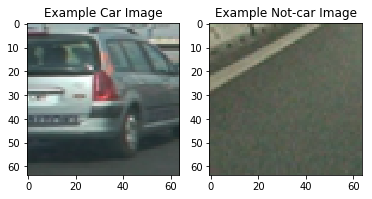

In [149]:
%matplotlib inline

# Load the car image file-names
car_images = glob.glob('data/vehicles/GTI_Far/*.png')
car_images.extend(glob.glob('data/vehicles/GTI_Left/*.png'))
car_images.extend(glob.glob('data/vehicles/GTI_MiddleClose/*.png'))
car_images.extend(glob.glob('data/vehicles/GTI_Right/*.png'))
car_images.extend(glob.glob('data/vehicles/KITTI_extracted/*.png'))

# Load the non-car image file-names
non_car_images = glob.glob('data/non-vehicles/GTI/*.png')
non_car_images.extend(glob.glob('data/non-vehicles/extras/*.png'))

# Shuffle the array
np.random.shuffle(car_images)
np.random.shuffle(non_car_images)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    print('There are', data_dict["n_cars"], ' cars and', data_dict["n_notcars"], ' non-cars')
    print('of size: ',data_dict["image_shape"], ' and data type:', data_dict["data_type"])
    
data_look(car_images, non_car_images)

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car_images))
notcar_ind = np.random.randint(0, len(non_car_images))
    
# Read in car / not-car images
car_image = mpimg.imread(car_images[car_ind])
notcar_image = mpimg.imread(non_car_images[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Functions

In [146]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_heat(image, box_list, threshold = 1):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return heatmap

## Classifier

In [58]:
def create_classifier(car_images, non_car_images, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, clf = False):
    car_features = extract_features(car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(non_car_images, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    car_features = np.nan_to_num(car_features)
    notcar_features = np.nan_to_num(notcar_features)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    
    if clf == False:
        # Use a linear SVC 
        clf = LinearSVC()
        
    # Check the training time for the SVC
    t=time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the CLF
    print('Test Accuracy of CLF = ', round(clf.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return X_scaler, clf


In [159]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, xstart, xstop, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_conv):
    window = 64
    # Instead of overlap, define how many cells to step
    cells_per_step = 2
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            conf = clf.decision_function(test_features)
            if test_prediction == 1: # and conf > 1:
                xbox_left = np.int(xleft*scale)+xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                
    return bboxes

In [154]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_conv = 'RGB2YCrCb' # Can be RGB2YCrCb, BGR2YCrCb, RGB2LUV, RGB2HSV, RGB2YUV
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [155]:
# init_clf = tree.DecisionTreeClassifier(min_samples_split=10)
X_scaler, clf = create_classifier(car_images[0:2000], non_car_images[0:2000], color_space, \
                                  spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, False)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.14 Seconds to train SVC...
Test Accuracy of CLF =  0.9862


In [189]:
class SearchVariables:
    def __init__(self, xstart, xstop, ystart, ystop, scale):
        self.xstart = xstart
        self.xstop = xstop
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale

def process_image(image, heatmap_queue=False):
    search_locations = [  
        SearchVariables(0, 1280, 400, 520, 1.0),
        SearchVariables(0, 1280, 400, 520, 1.2),
        SearchVariables(0, 1280, 400, 530, 1.4),
        SearchVariables(0, 1280, 410, 540, 1.6),
        SearchVariables(0, 1280, 410, 560, 2.0),
        SearchVariables(0, 1280, 410, 570, 2.2),
        SearchVariables(0, 1280, 420, 580, 2.4),
        SearchVariables(0, 1280, 420, 590, 2.6),
        SearchVariables(0, 1280, 420, 600, 2.8),   
        SearchVariables(0, 1280, 430, 610, 3.0),   
    ]
    
    all_bboxes = []
    for search_location in search_locations:
        bboxes = find_cars(image, search_location.xstart, search_location.xstop, \
                           search_location.ystart, search_location.ystop, \
                           search_location.scale, clf, X_scaler, orient, pix_per_cell, \
                           cell_per_block, spatial_size, hist_bins, color_conv)
        all_bboxes.extend(bboxes)
    
    windows = draw_boxes(image, all_bboxes)
    
    threshold = 1
    
    heatmap = find_heat(image, all_bboxes, threshold)
   
    current_heatmap = np.copy(heatmap)
    if heatmap_queue != False:
        heatmap = sum(heatmap_queue)
        
    # Find final boxes from heatmap using label function
    labels_heat = label(heatmap)
    
    detected_cars = draw_labeled_bboxes(image, labels_heat)
    
    return detected_cars, windows, current_heatmap, heatmap

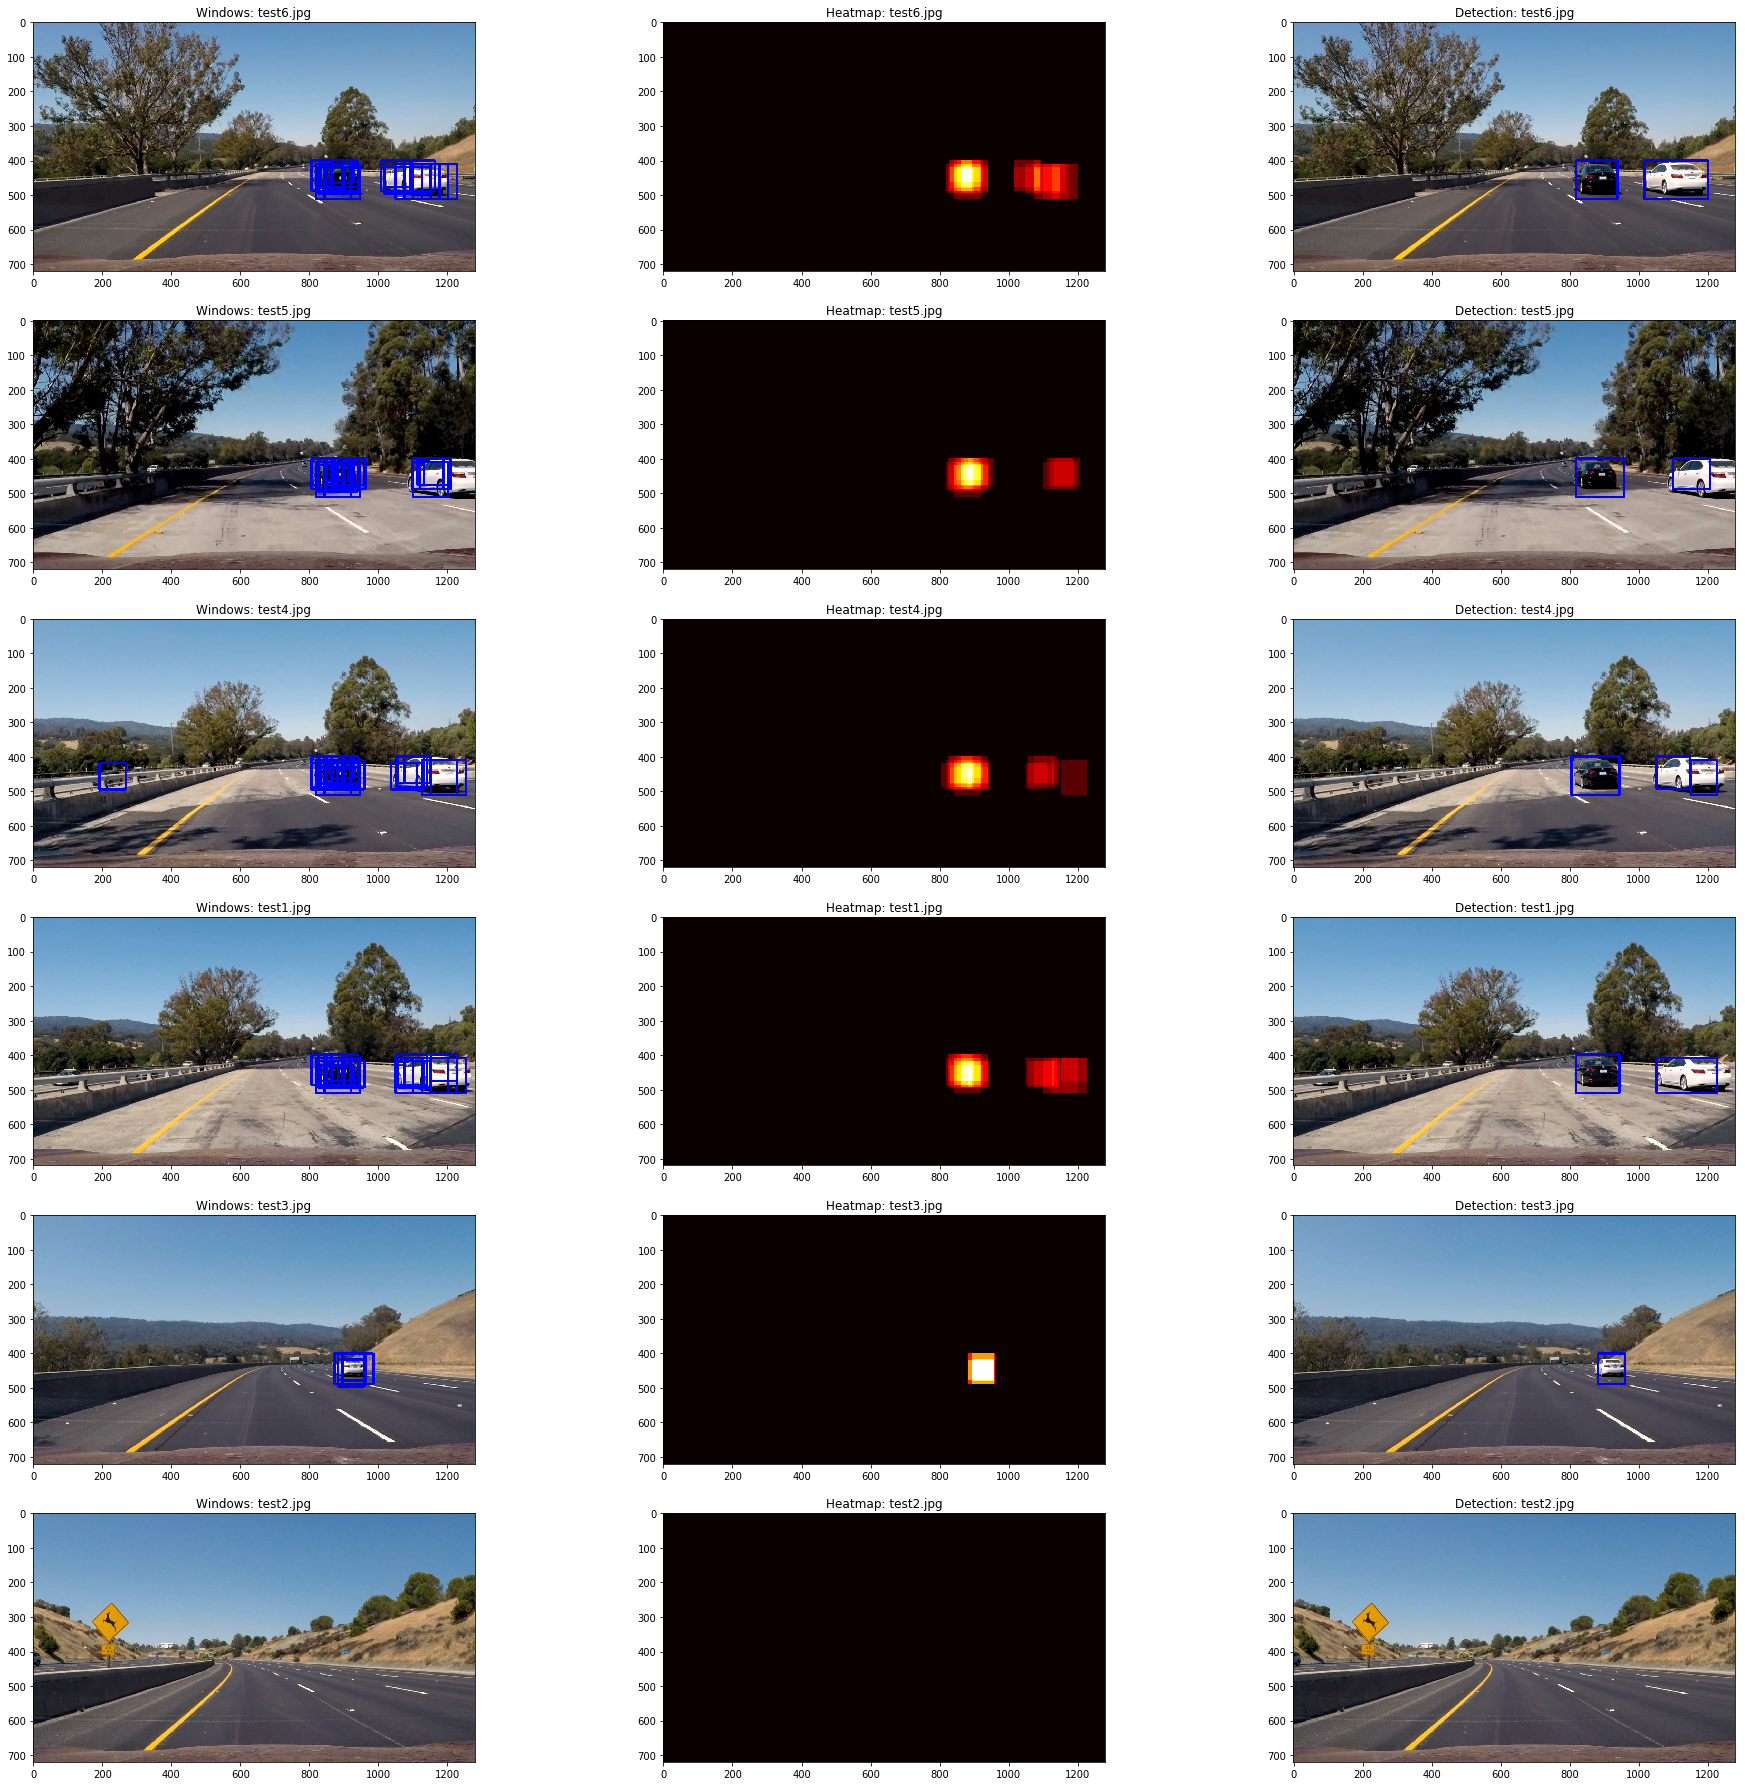

In [190]:
test_images = glob.glob('test_images/*.jpg')

f, axarr = plt.subplots(len(test_images), 3, figsize=(32,32))

for i, test_fname in enumerate(test_images):
    test_image = mpimg.imread(test_fname)
    
    fname_only = test_fname.split('/')[1]
    
    detected_cars, windows, current_heatmap, total_heatmap = process_image(test_image)
    
    axarr[i,0].set_title('Windows: ' + fname_only)
    axarr[i,0].imshow(windows)
    axarr[i,1].set_title('Heatmap: ' + fname_only)
    axarr[i,1].imshow(current_heatmap, cmap='hot')
    axarr[i,2].set_title('Detection: ' + fname_only)
    axarr[i,2].imshow(detected_cars)

    mpimg.imsave('output_images/'+fname_only, detected_cars)


In [184]:
# Rewrite image to frame processing
def process_frame(image):
    detected_cars, windows, current_heatmap, total_heatmap = process_image(image, heatmap_queue)
    heatmap_queue.append(current_heatmap)
    return detected_cars

In [185]:
heatmap_queue = collections.deque(maxlen=12)

output = 'output_images/test_video.mp4'
clip = VideoFileClip("test_video.mp4")
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:32<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 1min 3s, sys: 160 ms, total: 1min 3s
Wall time: 33.4 s


In [186]:
heatmap_queue = collections.deque(maxlen=12)

output = 'output_images/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(process_frame)
%time project_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [18:48<00:00,  1.16it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 36min 30s, sys: 6.72 s, total: 36min 36s
Wall time: 18min 49s
